# Data Cleaning Pipeline

In [1]:
# Only need to assign the two values below first, then run all
watershed = 'HarvardForest'
main_str = 'BigelowLower'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/12-Harvard/DailyData'

In [3]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [4]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2001-02-11                     NaN                  0.0                 -10.7   
2001-02-12                     NaN                  0.0                  -9.8   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2001-02-11                  14.9                    40.0                287.0   
2001-02-12                  14.8                    45.0                245.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2001-02-11              3.3        NaN         NaN                     NaN   
2001-02-12              1.7        NaN         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2001-02-11          NaN               NaN                           NaN   
2001-02-12          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2001-02-11                NaN                          NaN   
2001-02-12                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2001-02-11                         NaN                         NaN  
2001-02-12                         NaN                         NaN

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2020-08-30                  0.14                    2.78   
2020-08-31                  0.07                    1.37   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2020-08-30                    0.78                  0.0                  16.5   
2020-08-31                    0.27                  0.0                  15.5   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2020-08-30                  21.6                    70.0                290.0   
2020-08-31                  20.4                    74.0                167.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2020-08-30              1.7        0.0         NaN                     NaN   
2020-08-31              1.0        0.0         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2020-08-30          NaN               NaN                           NaN   
2020-08-31          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2020-08-30                NaN                          NaN   
2020-08-31                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2020-08-30                         NaN                        20.3  
2020-08-31                         NaN                        19.7

In [5]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['NelsonWeir' 'BigelowLower' 'BigelowUpper' 'HF001' 'HF155' 'Shaler'
 'LittleProspectHill' 'Hemlock' 'HF006']
  
Discharge stations : ['NelsonWeir', 'BigelowLower', 'BigelowUpper']
  
Meteorology stations: ['HF001', 'HF155', 'Shaler', 'LittleProspectHill', 'Hemlock', 'HF006']


In [6]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

BigelowLower_Discharge


In [7]:
len(nameHydrMetStation)

6

#  1. Trim the original table

In [8]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2001-02-11                     NaN                  0.0                 -10.7   
2001-02-12                     NaN                  0.0                  -9.8   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2001-02-11                  14.9                    40.0                287.0   
2001-02-12                  14.8                    45.0                245.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2001-02-11              3.3        NaN         NaN                     NaN   
2001-02-12              1.7        NaN         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2001-02-11          NaN               NaN                           NaN   
2001-02-12          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2001-02-11                NaN                          NaN   
2001-02-12                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2001-02-11                         NaN                         NaN  
2001-02-12                         NaN                         NaN

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2020-08-30                  0.14                    2.78   
2020-08-31                  0.07                    1.37   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2020-08-30                    0.78                  0.0                  16.5   
2020-08-31                    0.27                  0.0                  15.5   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2020-08-30                  21.6                    70.0                290.0   
2020-08-31                  20.4                    74.0                167.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2020-08-30              1.7        0.0         NaN                     NaN   
2020-08-31              1.0        0.0         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2020-08-30          NaN               NaN                           NaN   
2020-08-31          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2020-08-30                NaN                          NaN   
2020-08-31                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2020-08-30                         NaN                        20.3  
2020-08-31                         NaN                        19.7

trimmed row number is  0


### Drop columns without data

In [9]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


### Save the original discharge table seperately

In [10]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

 
0 NelsonWeir_Discharge :No missing data!
 
1 BigelowLower_Discharge :No missing data!
 
2 BigelowUpper_Discharge :No missing data!
 
3 HF001_Precipitation :No missing data!
4 HF001_AirTemperature index of interpolated length = 5
No filled values are out of original data range
 
5 HF001_SolarRadiation index of interpolated length = 15
No filled values are out of original data range
 
6 HF001_RelativeHumidity index of interpolated length = 31
No filled values are out of original data range
 
7 HF001_WindDirection index of interpolated length = 14
No filled values are out of original data range
 
8 HF001_WindSpeed index of interpolated length = 13
No filled values are out of original data range
 
 
9 HF155_SWE :No missing data!
10 Shaler_SWE index of interpolated length = 87
No filled values are out of original data range
 
11 LittleProspectHill_SWE index of interpolated length = 73
No filled values are out of original data range
 
12 Hemlock_SWE index of interpolated length = 113
No fi

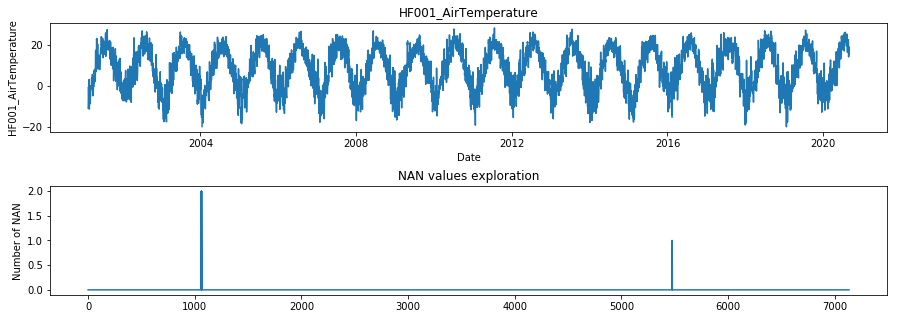

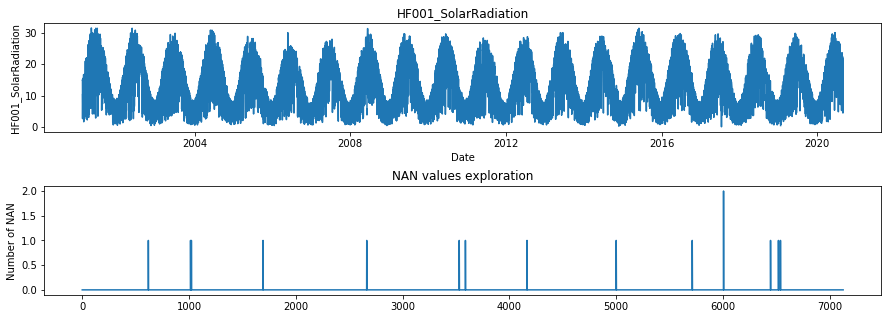

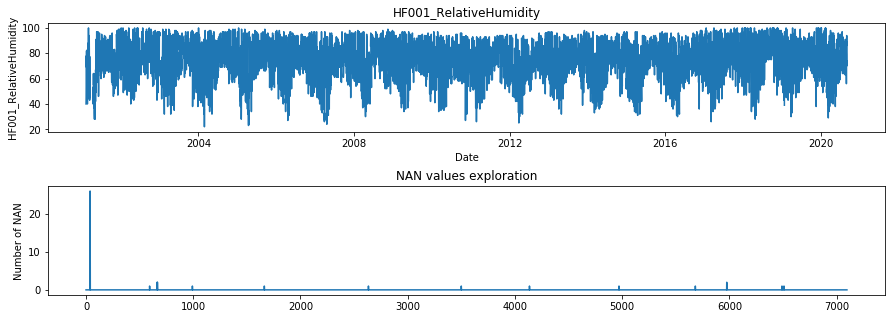

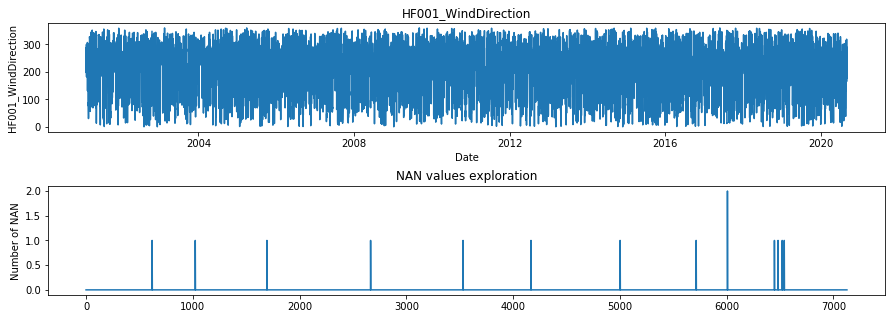

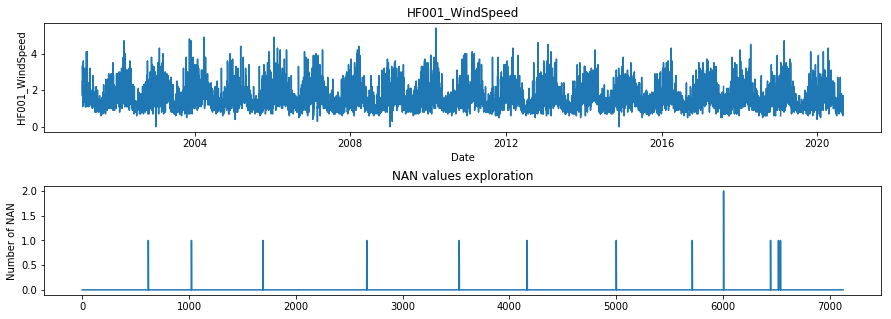

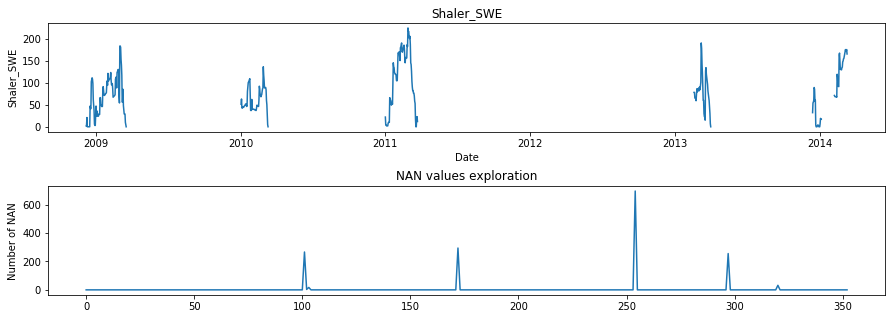

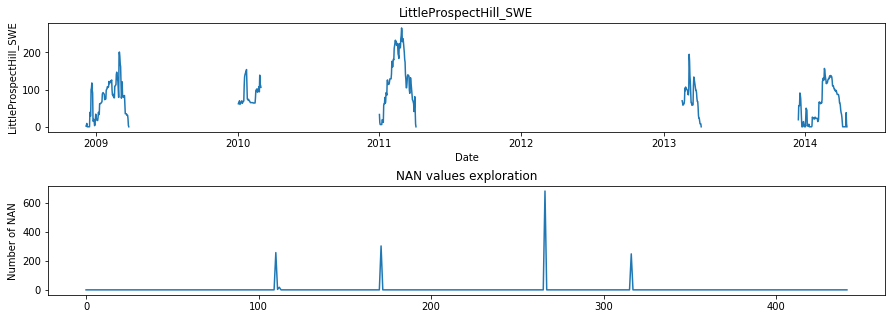

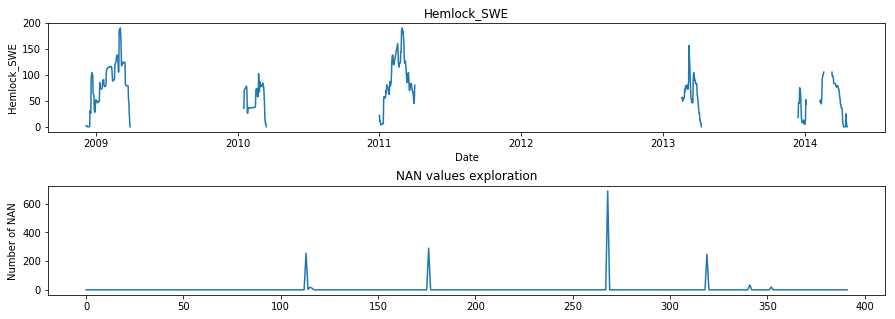

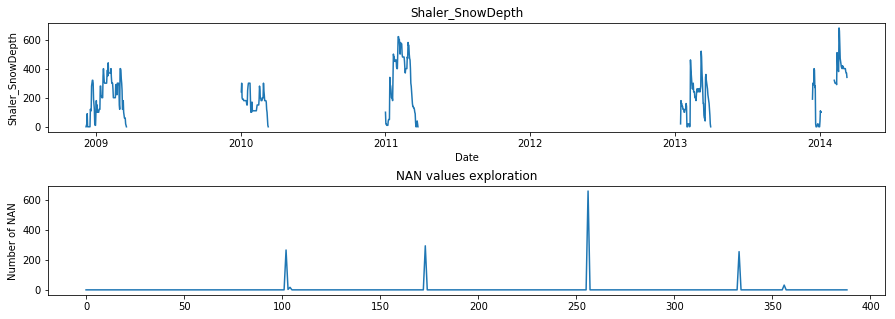

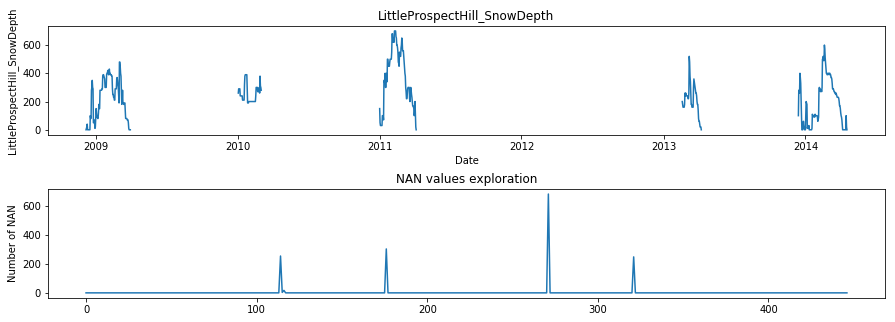

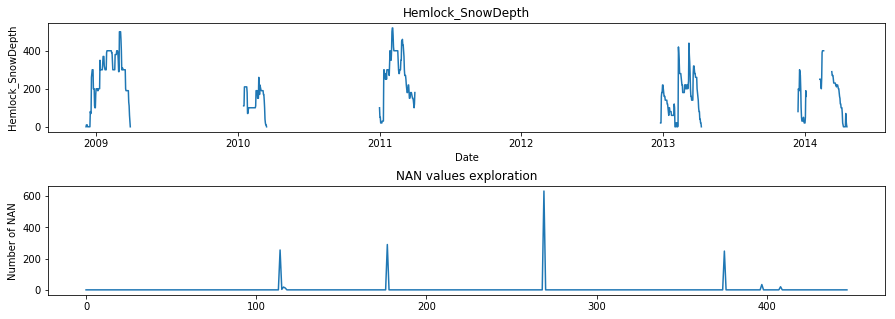

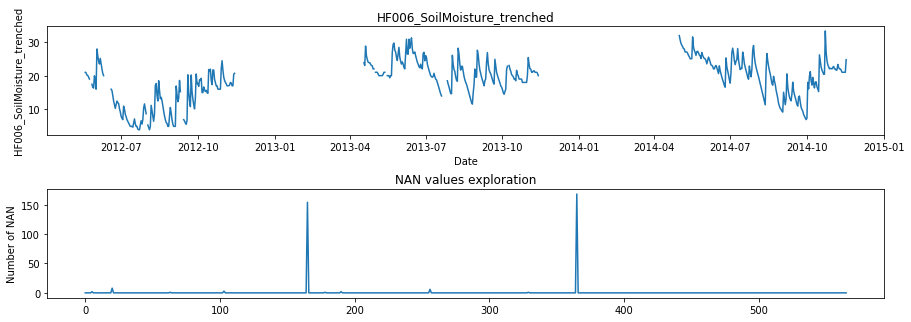

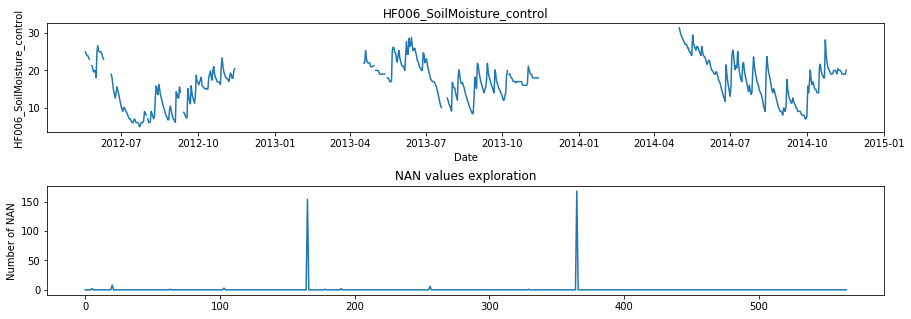

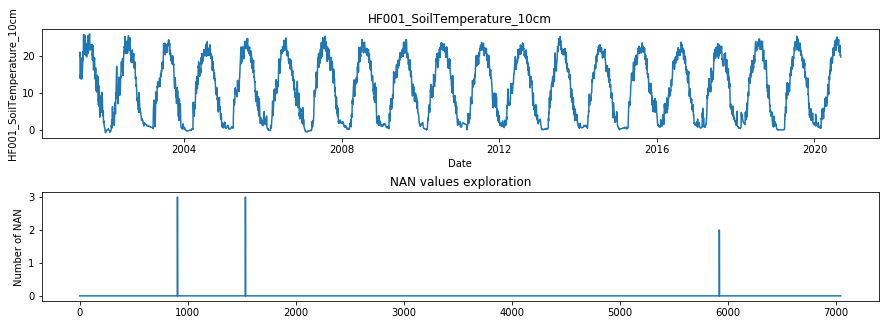

In [11]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [12]:
flag_table2.head(2)

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2001-02-11                     NaN                  1.0                   1.0   
2001-02-12                     NaN                  1.0                   1.0   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2001-02-11                   1.0                     1.0                  1.0   
2001-02-12                   1.0                     1.0                  1.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2001-02-11              1.0        NaN         NaN                     NaN   
2001-02-12              1.0        NaN         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2001-02-11          NaN               NaN                           NaN   
2001-02-12          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2001-02-11                NaN                          NaN   
2001-02-12                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2001-02-11                         NaN                         NaN  
2001-02-12                         NaN                         NaN

In [13]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [14]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [15]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [16]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation' 'AirTemperature' 'SolarRadiation'
 'RelativeHumidity' 'WindDirection' 'WindSpeed' 'SWE' 'SnowDepth'
 'SoilMoisture' 'SoilTemperature']


True

1 / 9 in process: NelsonWeir Discharge
 
No Precipitation data at station NelsonWeir
 
No AirTemperature data at station NelsonWeir
 
No SolarRadiation data at station NelsonWeir
 
No RelativeHumidity data at station NelsonWeir
 
No WindDirection data at station NelsonWeir
 
No WindSpeed data at station NelsonWeir
 
No SWE data at station NelsonWeir
 
No SnowDepth data at station NelsonWeir
 
No SoilMoisture data at station NelsonWeir
 
No SoilTemperature data at station NelsonWeir
 
2 / 9 in process: BigelowLower Discharge
 
No Precipitation data at station BigelowLower
 
No AirTemperature data at station BigelowLower
 
No SolarRadiation data at station BigelowLower
 
No RelativeHumidity data at station BigelowLower
 
No WindDirection data at station BigelowLower
 
No WindSpeed data at station BigelowLower
 
No SWE data at station BigelowLower
 
No SnowDepth data at station BigelowLower
 
No SoilMoisture data at station BigelowLower
 
No SoilTemperature data at station BigelowLower
 


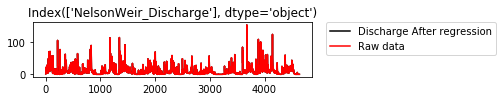

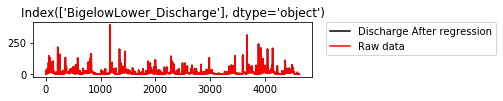

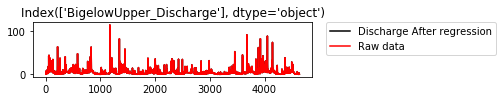

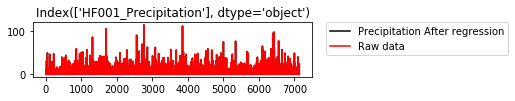

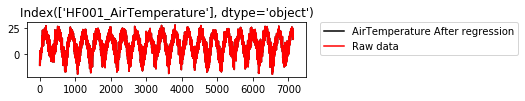

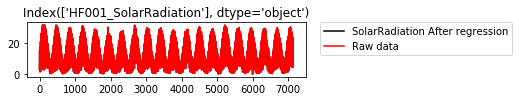

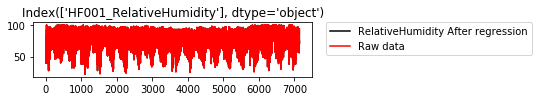

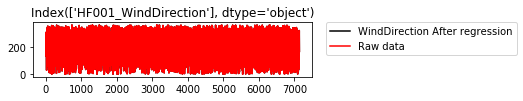

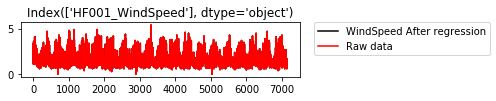

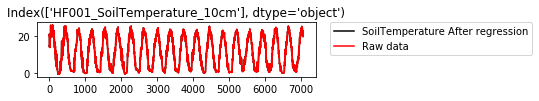

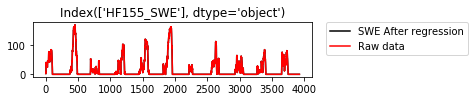

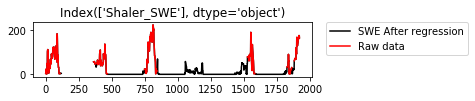

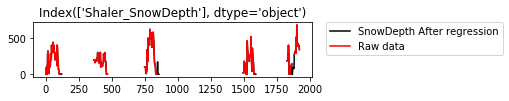

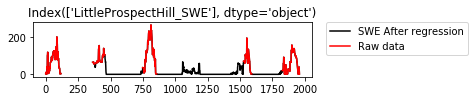

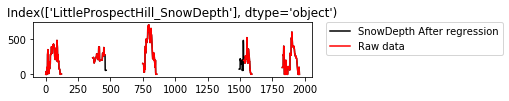

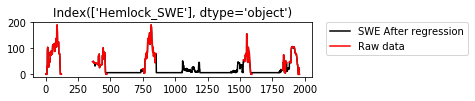

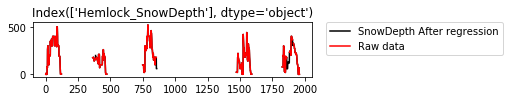

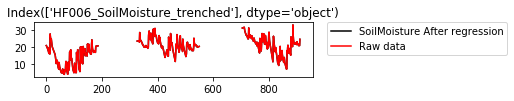

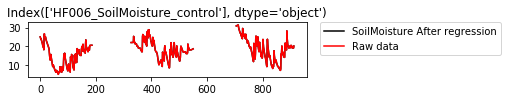

In [17]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [18]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [19]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3323
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3324
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3325
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3326
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3327
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3328
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3329
Shaler_SW

Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3507
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3508
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3509
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3510
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3511
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3512
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3513
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3514
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3515
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3516
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3517
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3518
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3519
Shaler_SWE Less than minimum, value -2.514023754630

Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3751
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3752
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3753
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3754
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3755
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3756
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3757
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3758
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3759
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3760
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3761
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3762
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3763
Shaler_SWE Less than minimum, value -2.514023754630

Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3895
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3896
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3897
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3898
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3899
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3900
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3901
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3902
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3903
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3904
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3905
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3906
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  3907
Shaler_SWE Less than minimum, value -2.514023754630

Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4171
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4172
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4173
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4174
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4175
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4176
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4177
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4178
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4179
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4180
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4181
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4182
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4183
Shaler_SWE Less than minimum, value -2.514023754630

Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4457
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4458
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4459
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4460
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4461
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4462
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4463
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4464
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4465
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4466
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4467
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4468
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4469
Shaler_SWE Less than minimum, value -2.514023754630

Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4591
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4592
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4593
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4594
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4595
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4596
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4597
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4598
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4599
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4600
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4601
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4602
Shaler_SWE Less than minimum, value -2.514023754630685 < 0 index =  4603
Shaler_SWE Less than minimum, value -2.514023754630

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3434
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3435
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3436
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3437
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3438
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3439
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3440
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3441
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3442
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3443
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3444
LittleProspectHill_SWE Less than minimum, value -1.898

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3534
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3535
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3536
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3537
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3538
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3539
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3540
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3541
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3542
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3543
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3544
LittleProspectHill_SWE Less than minimum, value -1.898

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3800
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3801
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3802
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3803
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3804
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3805
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3806
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3807
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3808
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3809
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  3810
LittleProspectHill_SWE Less than minimum, value -1.898

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4080
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4081
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4082
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4083
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4084
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4085
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4086
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4087
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4088
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4089
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4090
LittleProspectHill_SWE Less than minimum, value -1.898

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4228
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4229
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4230
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4231
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4232
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4233
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4234
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4235
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4236
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4237
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4238
LittleProspectHill_SWE Less than minimum, value -1.898

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4502
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4503
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4504
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4505
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4506
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4507
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4508
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4509
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4510
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4511
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4512
LittleProspectHill_SWE Less than minimum, value -1.898

LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4627
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4628
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4629
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4630
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4631
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4632
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4633
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4634
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4635
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4636
LittleProspectHill_SWE Less than minimum, value -1.8982736217433427 < 0 index =  4637
LittleProspectHill_SWE Less than minimum, value -1.898

In [20]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [21]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   

            BigelowUpper_Discharge  
DateTime                            
2001-02-11                     NaN  
2001-02-12                     NaN

In [22]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:135: RuntimeWarning: Mean of empty slice
  AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:137: RuntimeWarning: All-NaN slice encountered
  AnnualMax = (np.nanmax(AnnualTable,axis=0)) # for outliers MAx
/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:138: RuntimeWarning: All-NaN slice encountered
  AnnualMin = (np.nanmin(AnnualTable,axis=0)) # minimum


0 NelsonWeir_Discharge 0
1 BigelowLower_Discharge 0
2 BigelowUpper_Discharge 0
3 HF001_Precipitation 0
4 HF001_AirTemperature 0
5 HF001_SolarRadiation 0
6 HF001_RelativeHumidity 12
7 HF001_WindDirection 0
8 HF001_WindSpeed 0
9 HF155_SWE 0
10 Shaler_SWE 0
11 LittleProspectHill_SWE 0
12 Hemlock_SWE 0
13 Shaler_SnowDepth 0
14 LittleProspectHill_SnowDepth 0
15 Hemlock_SnowDepth 0
16 HF006_SoilMoisture_trenched 0
17 HF006_SoilMoisture_control 0
18 HF001_SoilTemperature_10cm 0


In [23]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [24]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [25]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [26]:
table4.head()

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   
2001-02-13                   NaN                     NaN   
2001-02-14                   NaN                     NaN   
2001-02-15                   NaN                     NaN   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2001-02-11                     NaN                  0.0                 -10.7   
2001-02-12                     NaN                  0.0                  -9.8   
2001-02-13                     NaN                  0.0                  -2.0   
2001-02-14                     NaN                  6.9                  -0.5   
2001-02-15                     NaN                  0.0                  -0.4   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2001-02-11                  14.9                    40.0                287.0   
2001-02-12                  14.8                    45.0                245.0   
2001-02-13                  14.8                    70.0                278.0   
2001-02-14                   2.6                    78.0                197.0   
2001-02-15                  10.5                    69.0                300.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2001-02-11              3.3        NaN         NaN                     NaN   
2001-02-12              1.7        NaN         NaN                     NaN   
2001-02-13              1.7        NaN         NaN                     NaN   
2001-02-14              2.5        NaN         NaN                     NaN   
2001-02-15              1.6        NaN         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2001-02-11          NaN               NaN                           NaN   
2001-02-12          NaN               NaN                           NaN   
2001-02-13          NaN               NaN                           NaN   
2001-02-14          NaN               NaN                           NaN   
2001-02-15          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2001-02-11                NaN                          NaN   
2001-02-12                NaN                          NaN   
2001-02-13                NaN                          NaN   
2001-02-14                NaN                          NaN   
2001-02-15                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2001-02-11                         NaN                         NaN  
2001-02-12                         NaN                         NaN  
2001-02-13                         NaN                         NaN  
2001-02-14                         NaN                         NaN  
2001-02-15                         NaN                         NaN

In [27]:
flag_table4.head()

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   
2001-02-13                   NaN                     NaN   
2001-02-14                   NaN                     NaN   
2001-02-15                   NaN                     NaN   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2001-02-11                     NaN                  1.0                   1.0   
2001-02-12                     NaN                  1.0                   1.0   
2001-02-13                     NaN                  1.0                   1.0   
2001-02-14                     NaN                  1.0                   1.0   
2001-02-15                     NaN                  1.0                   1.0   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2001-02-11                   1.0                     1.0                  1.0   
2001-02-12                   1.0                     1.0                  1.0   
2001-02-13                   1.0                     1.0                  1.0   
2001-02-14                   1.0                     1.0                  1.0   
2001-02-15                   1.0                     1.0                  1.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2001-02-11              1.0        NaN         NaN                     NaN   
2001-02-12              1.0        NaN         NaN                     NaN   
2001-02-13              1.0        NaN         NaN                     NaN   
2001-02-14              1.0        NaN         NaN                     NaN   
2001-02-15              1.0        NaN         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2001-02-11          NaN               NaN                           NaN   
2001-02-12          NaN               NaN                           NaN   
2001-02-13          NaN               NaN                           NaN   
2001-02-14          NaN               NaN                           NaN   
2001-02-15          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2001-02-11                NaN                          NaN   
2001-02-12                NaN                          NaN   
2001-02-13                NaN                          NaN   
2001-02-14                NaN                          NaN   
2001-02-15                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2001-02-11                         NaN                         NaN  
2001-02-12                         NaN                         NaN  
2001-02-13                         NaN                         NaN  
2001-02-14                         NaN                         NaN  
2001-02-15                         NaN                         NaN

In [28]:
table4.shape

(7142, 19)

In [29]:
flag_table4.shape

(7142, 19)